# Knee Joint Replacement Prediction Regression Model

I recently finished an in-depth data exploration on the regional healthcare costs in New York State where I singled out knee joint replacement surgeries as one the most common medical procedures performed, and one of the most expensive (costs can vary by more than 100,000 USD). [Analysis Here](https://towardsdatascience.com/data-analysis-of-new-york-state-regional-healthcare-costs-d72fb579601f?sk=daaf2cd532299476b6e0314ad109fa09)

Despite only a moderate increase in [patient volumes](https://medium.com/@mramire6/healthcare-costs-in-new-york-state-b7672ade9492) (11,000 new patients treated in 2016 compared to 2009) their costs have skyrocketed over time. In an effort to help New York State residents financially plan for this medical procedure, I decided to build a machine learning model that could predict the cost of a knee joint replacement surgery. My goal was to have this model complement other healthcare cost estimators available to give patients more financial information. I framed this problem as a supervised regression task using a single batch of data.

## Workflow:
1. Frame the problem and look at the big picture.
2. Get the data.
3. Explore the data to gain insights.
4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. Explore many different models and short-list the best ones.
6. Fine-tune your models and combine them into a great solution. __In Progress__
7. Present your solution. __Incomplete__
8. Launch, monitor, and maintain your system. __Incomplete__

## Frame the Problem and look at the big picture.

- Supervised Regression Model. 1 batch of data. Offline.
- Who is the model for? Consumers who want to get an additional estimate on their health insurance cost.
- Why? The more the better (especially when you only get 1 value from your provider, if you have one). 
- What will the model output? An estimated cost with an error.
- What diseases will it work for? It will initially work only for knee joint replacement surgery.
- Why will it only work for this disease? My previous analysis showed it to be one of the more interesting conditions to look at and one with high variability in costs.

## 2. Get the Data

In [1]:
#Import the necessary libraries to perform exploratory data analysis

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

The data was obtained from the NYS Department of Health [website.](https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/gnzp-ekau) This data is 2016 Hospital Inpatient Discharges (SPARCS de-identified). It contains basic record level detail for individual discharges. 

From my previous __[analysis](https://towardsdatascience.com/data-analysis-of-new-york-state-regional-healthcare-costs-d72fb579601f)__, knee joint replacement surgery was one of the most interesting medical conditions. Let's build a model to predict its charge. 

In [2]:
#Read the .csv file
df_original = pd.read_csv('../Blog Post 3/Hospital_Inpatient_Discharges_SPARCS_DeIdentified_2016_KneeReplacement_Only.csv')

#Make a copy and work through the copy.
df = df_original.copy()

#Get an initial impression of the dataframe.
df.head()

/Users/manuelramirez/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,...,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
0,35,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,M,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,23344.75,11281.89,0.483273
1,36,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,F,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,25154.00,12415.67,0.493586
2,101,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,F,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,29389.50,14873.56,0.506084
3,103,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,M,White,...,Private Health Insurance,213053.0,213053.0,NaN,0,N,N,25029.50,12402.49,0.495515
4,106,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,70 or Older,148,F,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,28976.00,14547.43,0.502051


In [3]:
#There are now 39,824 instances and they are now all related to knee joint replacement surgery. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39824 entries, 0 to 39823
Data columns (total 39 columns):
Unnamed: 0                               39824 non-null int64
Health Service Area                      39824 non-null object
Hospital County                          39824 non-null object
Operating Certificate Number             39824 non-null float64
Facility Id                              39824 non-null float64
Facility Name                            39824 non-null object
Age Group                                39824 non-null object
Zip Code - 3 digits                      39806 non-null object
Gender                                   39824 non-null object
Race                                     39824 non-null object
Ethnicity                                39824 non-null object
Length of Stay                           39824 non-null object
Type of Admission                        39824 non-null object
Patient Disposition                      39824 non-null object
Discharg

Notice how some of the feature columns do not add up to 39,824. There are some zip codes missing, payment typology 2, payment typology 3, other provider license number that are missing entries.

In [48]:
#Let's work through the columns, identify those we can eliminate, and drop them. We want to eliminate redundant information or
#information a patient may not know on their own.

df.columns.tolist() #Output below

#Comment those columns we want to keep.
col2drop = ['Health Service Area', #This is their designation for hospital region. Drop it since we'll use our own. Drop. 
            #'Hospital County',                                                              #Data Type: Nominal
            'Operating Certificate Number', #We do not need the operating certificate number of the facility. Drop. 
            #'Facility Id',                                                                  #Data Type: Nominal
            #'Facility Name',                                                                #Data Type: Nominal
            #'Age Group',                                                                    #Data Type: Ordinal
            'Zip Code - 3 digits', #We won't incorporate socioeconomic status of the patient. Drop.
            #'Gender',                                                                       #Data Type: Nominal
            #'Race',                                                                         #Data Type: Nominal
            #'Ethnicity',                                                                    #Data Type: Nominal
            #'Length of Stay',                                                               #Data Type: Ordinal
            #'Type of Admission',                                                            #Data Type: Nominal
            #'Patient Disposition',                                                          #Data Type: Nominal
            'Discharge Year', #We know the discharge year is 2016. Drop. 
            'CCS Diagnosis Code', #Additional information not needed since we are basing codes on APR DRG. Drop. 
            'CCS Diagnosis Description', #Same as above. Drop. 
            'CCS Procedure Code', #Additional information not needed since we are basing codes on APR DRG. Drop. 
            'CCS Procedure Description', #Same as above. Drop. 
            'APR DRG Code', #We've already filtered out the other conditions so we don't need this anymore. Drop. 
            'APR DRG Description', #Same as above. Drop. 
            'APR MDC Code', #Additional information not needed. We know knee joint replacement is related to musculoskeletal. Drop.
            'APR MDC Description', #Same as above. Drop. 
            #'APR Severity of Illness Code',                                                 #Data Type: Ordinal
            #'APR Severity of Illness Description',                                          #Data Type: Ordinal
            #'APR Risk of Mortality',                                                        #Data Type: Ordinal
            'APR Medical Surgical Description', #Joint knee replacement is a surgical procedure. This is already known. Drop.
            #'Payment Typology 1',                                                           #Data Type: Nominal
            #'Payment Typology 2',                                                           #Data Type: Nominal
            #'Payment Typology 3',                                                           #Data Type: Nominal
            'Attending Provider License Number', #Patients would not realistically know this level of information. Drop. 
            'Operating Provider License Number', #Patients would not realistically know this level of information. Drop. 
            'Other Provider License Number', #Patients would not realistically know this level of information. Drop. 
            'Birth Weight', #Relevant only to newborns. Drop. 
            'Abortion Edit Indicator', #Relevant only for abortion medical procedures. Drop. 
            #'Emergency Department Indicator',                                               #Data Type: Binary
            #'Total Charges',                                                                #Data Type: Continuous
            #'Total Costs',                                                                  #Data Type: Continuous
            #'Ratio of Total Costs to Total Charges'                                         #Data Type: Continuous
             ]
df = df.drop(labels=col2drop,axis=1).reset_index(drop=True)

***

## 3. Discover, explore and visualize the data to gain insights

In [49]:
def dataexplore_pie(df,column_label):
    
    random_i = np.random.permutation(len(df.loc[:,column_label].value_counts()))
    
    category_labels = df.loc[:,column_label].value_counts()[random_i].index
    values = df.loc[:,column_label].value_counts()[random_i]
    values_perc = values / values.sum() * 100
    
    wedgeprops = {'linewidth':1.5,'edgecolor':'black'}
    textprops = {'fontsize':13,'fontstyle':'italic'}

    annotated_labels = [category_labels.tolist()[i] + ', ' + str(values_perc[i].round(2)) + '%' \
                        for i in range(0,len(category_labels))]

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)  
    ax.pie(values_perc,wedgeprops=wedgeprops,labels=annotated_labels,textprops=textprops)
    
    plt.show()

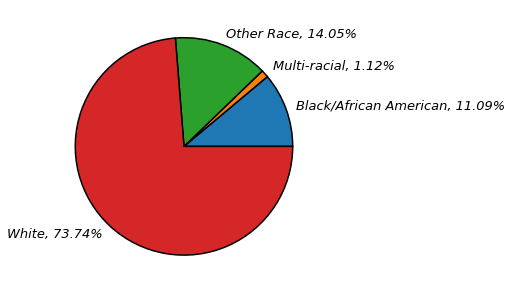

In [50]:
dataexplore_pie(df,'Race')

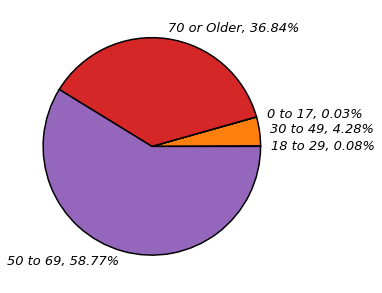

In [51]:
dataexplore_pie(df,'Age Group')

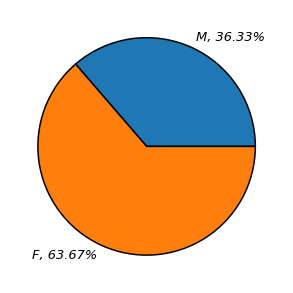

In [52]:
dataexplore_pie(df,'Gender')

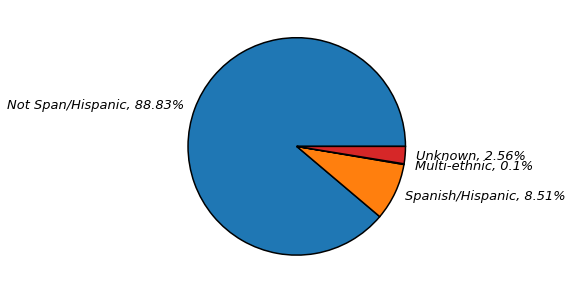

In [53]:
dataexplore_pie(df,'Ethnicity')

***

## 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.

__Go through column by column modifying it to better fit the underlying data patterns in ML algorithms.__

In [54]:
#Let's go through each column in order. We'll skip Hospital County since it will be used for 
#feature engineering at the end.
df.columns.tolist()

['Hospital County',
 'Facility Id',
 'Facility Name',
 'Age Group',
 'Gender',
 'Race',
 'Ethnicity',
 'Length of Stay',
 'Type of Admission',
 'Patient Disposition',
 'APR Severity of Illness Code',
 'APR Severity of Illness Description',
 'APR Risk of Mortality',
 'Payment Typology 1',
 'Payment Typology 2',
 'Payment Typology 3',
 'Emergency Department Indicator',
 'Total Charges',
 'Total Costs',
 'Ratio of Total Costs to Total Charges']

__Facility Id and Facility Name__

Facility Id and Facility name both refer to the same information. I'll keep Facility Id since it is easier to work with than a string of names. The Id tag to the facility poses an interesting challenge. It would certainly be one of the input features a patient would know. However, because this feature has high cardinality, encoding it is a challenge. OneHotEncoding would generate too many columns and we'd end up with the curse of dimensionality. <br>

Instead, I'll incorporate the lattitude/longitude information for each hospital. In my previous __[blog post](https://towardsdatascience.com/data-analysis-of-new-york-state-regional-healthcare-costs-d72fb579601f)__ I used the General Healthcare Facility to obtain this information. I will use it again here.

In [55]:
#Facility Id and Facility name both refer to the same information. I'll keep Facility Id since it is easier to work with.
#First, I'll create a new dataframe that maps the two together. 
df_hosp_id = df.loc[:,['Facility Id','Facility Name']].drop_duplicates(keep='first')
df_hosp_id.head()

,Facility Id,Facility Name
0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...
24,66.0,Olean General Hospital
103,98.0,Brooks Memorial Hospital
277,103.0,Woman's Christian Association
288,114.0,TLC Health Network Lake Shore Hospital


__Facility Id.__

In [56]:
#Read health facility general information dataset
df_healthfacility = pd.read_csv('../Blog Post 2/Health_Facility_General_Information.csv',usecols=['Facility ID','Facility Latitude','Facility Longitude'])

In [57]:
#Merge the general health facility dataframe based on facility ids.
df = df.merge(df_healthfacility,
              how='left',
              left_on='Facility Id',
              right_on='Facility ID')
df = df.drop(columns='Facility ID')

In [58]:
#Double check to see all facilities have their corresponding lattitude and longitude information.
df.loc[df.loc[:,'Facility Latitude'].isna(),'Facility Id'].unique() 

#2 Facilities did not. 

array([ 776., 3376.])

In [59]:
#What are their names?
df.loc[df.loc[:,'Facility Latitude'].isna(),'Facility Name'].unique()

array(['Nyack Hospital',
       "Long Island Jewish Schneiders Children's Hospital Division"],
      dtype=object)

In [60]:
#Add the lattitude/longitude information for each. I used Google Maps to find the facility by its name 
#and got its geotags.
df.loc[df.loc[:,'Facility Name'] == 'Nyack Hospital','Facility Latitude'] = 41.097133
df.loc[df.loc[:,'Facility Name'] == 'Nyack Hospital','Facility Longitude'] = -73.926049

df.loc[df.loc[:,'Facility Name'] == "Long Island Jewish Schneiders Children's Hospital Division",'Facility Latitude'] = 40.753661
df.loc[df.loc[:,'Facility Name'] == "Long Island Jewish Schneiders Children's Hospital Division",'Facility Longitude'] = -73.707514

In [61]:
#I also made sure to add the missing geotags back into the general health facility dataframe for reference.
missing_geotags = {'Facility ID':[776,3376],
                   'Facility Latitude':[41.097133,-73.926049],
                   'Facility Longitude':[40.753661,-73.707514]}
df_healthfacility = df_healthfacility.append(pd.DataFrame.from_dict(missing_geotags),sort=False,ignore_index=True)

In [62]:
#Double check to see all facilities have their corresponding lattitude and longitude information. 
df.loc[df.loc[:,'Facility Latitude'].isna(),'Facility Name'].unique() 

#No missing information is present.

array([], dtype=object)

_We'll keep the facility Id and facility name until we are finished encoding/feature engineering. Then we will drop them._

__Age Group__

In [63]:
#What are the age group labels?
age_group_labels = (df.loc[:,'Age Group']).astype('category').cat.categories.tolist()
age_group_labels

#This feature can be replaced with a label encoder. It is also ordinal.  

['0 to 17', '18 to 29', '30 to 49', '50 to 69', '70 or Older']

In [64]:
#Replace the age groups with a numerical encoding.
replace_age_group = {'Age Group': {k: v for k,v in zip(age_group_labels,list(range(1,len(age_group_labels)+1)))}}
df = df.replace(replace_age_group)
#replace_age_group

__Gender__

In [65]:
#What are the Gender labels?
(df.loc[:,'Gender']).unique().tolist()
#This feature can be replaced with a label encoder. It is binary.

['M', 'F']

In [66]:
#Replace the gender with a binary numerical encoding.
gender_labels = (df.loc[:,'Gender']).unique().tolist()
replace_gender = {'Gender':{'M':0,'F':1}}
replace_gender
df = df.replace(replace_gender)

__Length of Stay__

_Nobody really knows for sure how long you'll stay in the hospital after a surgery. Hopefully, it's as little time as possible. The data reports the exact number of days, but realistically, you'd only know a range of days depending on how you heal. Therefore binning this category makes the most amount of sense. I decided to make two bins. Above or below 5 days at the hospital._

In [67]:
#What are the values for length of stay?
df['Length of Stay'].unique()

array(['3', '4', '6', '13', '5', '11', '8', '2', '1', '15', '7', '20',
       '10', '9', '14', '49', '37', '16', '23', '12', '22', '44', '21', 6,
       1, 2, 5, 4, 3, 7, 8, 44, 42, 15, 9, '17', '18', 11, 13, '47', '25',
       19, '35', '19', '36', 20, 14, 10, '70', '71', '59', '120 +', '31',
       '43', '102', '58', '55', '30', '78', '48', '24', '29', '38', '42',
       '34', 17, 18, 27, '27'], dtype=object)

_First, correct the entry that is non-numerical. There is a label for patients who stay longer than 120 days (labeled as '120 +'). Since we do not know exactly how many days above 120 the patients stayed for, I will simply change this value to 120._ 

In [68]:
#Change 120+ to 120
df.loc[df.loc[:,'Length of Stay'] == '120 +','Length of Stay'] = 120

In [69]:
(df.loc[:,'Length of Stay'].value_counts() / df.shape[0] * 100).head()

3    37.828947
2    27.430695
4     9.185416
1     6.021495
5     3.643532
Name: Length of Stay, dtype: float64

In [70]:
#Bin Cast True/False boolean series to 1/0 values.
df['Length of Stay'] = df['Length of Stay'].astype('uint8')
df['Length of Stay'] = (df.loc[:,'Length of Stay'] < 5).astype('uint8')

#Create a dict for reference in the future if needed.
replace_lengthofstay = {'Less than 5 days':1,'More than 5 days':0}

__Type of Admission.__

In [71]:
#What are the values for type of admission?
df.loc[:,'Type of Admission'].value_counts() / df.loc[:,'Type of Admission'].value_counts().sum() * 100

Elective         96.411712
Emergency         1.908397
Urgent            1.624648
Newborn           0.035155
Not Available     0.012555
Trauma            0.007533
Name: Type of Admission, dtype: float64

_As expected, knee joint replacement surgery is an elective surgery. However, between 1% - 2% of patients are labelled as emergency or urgent. The other categories are negligible. Let's combine newborn, not available and trauma as 'Other Admission Type'_

In [72]:
top_admission_type = df.loc[:,'Type of Admission'].value_counts().index[0:4].tolist()
bool_admission_type = df.loc[:,'Type of Admission'].isin(top_admission_type)
df.loc[~bool_admission_type,'Type of Admission'] = 'Other Admission Type'

__Patient Disposition.__

In [73]:
df.loc[:,'Patient Disposition'].unique().size

19

In [74]:
df.loc[:,'Patient Disposition'].value_counts() / df.loc[:,'Patient Disposition'].value_counts().sum() * 100

Home w/ Home Health Services             45.025613
Skilled Nursing Home                     26.705002
Home or Self Care                        20.439936
Inpatient Rehabilitation Facility         6.842607
Short-term Hospital                       0.399257
Hosp Basd Medicare Approved Swing Bed     0.135597
Another Type Not Listed                   0.123041
Cancer Center or Children's Hospital      0.072820
Court/Law Enforcement                     0.050221
Hospice - Home                            0.047710
Expired                                   0.042688
Facility w/ Custodial/Supportive Care     0.030133
Left Against Medical Advice               0.027622
Medicaid Cert Nursing Facility            0.017577
Hospice - Medical Facility                0.017577
Psychiatric Hospital or Unit of Hosp      0.007533
Medicare Cert Long Term Care Hospital     0.007533
Federal Health Care Facility              0.005022
Critical Access Hospital                  0.002511
Name: Patient Disposition, dtyp

_Patient dispostion related to what happened to the patient after they left the hospital. 99% of patients fell into 4 categories. They either went home with home health services, went into a skilled nursing home, went home without a home health service (self care) or went into an inpatient rehab facility. Again, let's combine all the other cateogires and label them as 'Other Disposition'._

In [75]:
#Replace all 15 categories as 'Other'

#Create list of names of the top patient disposition categories
top_patient_disp = df.loc[:,'Patient Disposition'].value_counts().index[0:4].tolist() 

#Create boolean mask for all the entries that have one of the names of the top patient disposition categories
bool_patient_disp = df.loc[:,'Patient Disposition'].isin(top_patient_disp)

#Replace all the False values to Other Disposition
df.loc[~bool_patient_disp,'Patient Disposition'] = 'Other Disposition'

__Severity of Illness__

In [76]:
#Severity of Illness is self explanatory. Let's create a mapping for it and use the code values (since they are inherently
#numerical) as a label encoder within our dataframe.
df_SOI_id = df.loc[:,['APR Severity of Illness Code','APR Severity of Illness Description']].drop_duplicates(keep='first')
df_SOI_id

,APR Severity of Illness Code,APR Severity of Illness Description
0,1,Minor
3,2,Moderate
5,4,Extreme
6,3,Major


In [77]:
df = df.drop(labels=['APR Severity of Illness Description'],axis=1).reset_index(drop=True)

__Risk of Mortality.__

In [78]:
#Risk of Mortality is also self explanatory. In this dataframe however it is explained with strings. Let's replace them with
#numerical values instead. 
APR_risk_mort_dict = {'Minor':1,'Moderate':2,'Extreme':3,'Major':4}
df.loc[:,'APR Risk of Mortality'] = df.loc[:,'APR Risk of Mortality'].map(APR_risk_mort_dict)

__Payment Typology.__

There are 3 columns for payment typology. They refer to how the patient paid for the procedure. 

In [79]:
df.loc[:,['Payment Typology 1','Payment Typology 2','Payment Typology 3']].head()

,Payment Typology 1,Payment Typology 2,Payment Typology 3
0,Private Health Insurance,Self-Pay,Self-Pay
1,Blue Cross/Blue Shield,Self-Pay,Self-Pay
2,Medicare,Medicaid,Self-Pay
3,Medicare,Blue Cross/Blue Shield,Private Health Insurance
4,Medicare,Medicare,Self-Pay


In [80]:
df.loc[:,'Payment Typology 1'].unique().tolist()

['Private Health Insurance',
 'Blue Cross/Blue Shield',
 'Medicare',
 'Self-Pay',
 'Medicaid',
 'Miscellaneous/Other',
 'Federal/State/Local/VA',
 'Department of Corrections',
 'Managed Care, Unspecified',
 'Unknown']

There are 11 different ways a patient can pay (one category is NaN which is included in Payment Typology 2 and Payment Typology 3, but not Payment Typology 1). What I will do is create 10 different categories and mark 1 or 0 (like OneHotEncoding) if a patient used this type of payment. Repeat payments will not be considered (i.e. if medicaid came in two times it will only be listed once). NaNs will be combined with the 'Unknown' category. 

In [81]:
df.loc[:,['Payment Typology 1','Payment Typology 2','Payment Typology 3']].fillna(value='Unknown') #Replace NaN's

payment_typology = df.loc[:,'Payment Typology 1'].unique().tolist() #Get list of new column names
df[payment_typology] = pd.DataFrame(np.zeros((df.shape[0],len(payment_typology))),index=df.index) #Add columns

#Label Encoding for Payment Typology
for payment in payment_typology:
    b_payment = (df.loc[:,['Payment Typology 1','Payment Typology 2','Payment Typology 3']] == payment)
    df.loc[np.nonzero(b_payment.sum(axis=1))[0],payment] = 1
    df[payment] = df[payment].astype(dtype='uint8')

#Drop old column names
df = df.drop(labels=['Payment Typology 1','Payment Typology 2','Payment Typology 3'],axis=1).reset_index(drop=True)

#New column names
payment_typology_mapper = {payment_name:(str('Payment Typology_') + payment_name) for payment_name in payment_typology}
df = df.rename(columns=payment_typology_mapper)    

In [83]:
df.iloc[:,18:].head()

,Payment Typology_Private Health Insurance,Payment Typology_Blue Cross/Blue Shield,Payment Typology_Medicare,Payment Typology_Self-Pay,Payment Typology_Medicaid,Payment Typology_Miscellaneous/Other,Payment Typology_Federal/State/Local/VA,Payment Typology_Department of Corrections,"Payment Typology_Managed Care, Unspecified",Payment Typology_Unknown
0,1,0,0,1,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0
2,0,0,1,1,1,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0


__Emergency Department Indicator.__

In [84]:
#This feature can be replaced with a label encoder. It is binary.
ed_indicator_labels = ['N','Y']
replace_ed_indicator = {'Emergency Department Indicator':{'Y':0,'N':1}}
df = df.replace(replace_ed_indicator)

***

## Feature Engineering

In my previous analysis I had created new terms to analyze hospital costs. I'll incorporate them here as well. 
- The first will be adding 1 of the 9 geographical regions to the hospital. 
- The second will denote the relative cost of the hospital in 3 different scales (at the NYS scale, at the regional scale, at the county scale). 
- The third will denote the market share of the hospital by knee joint replacmeent patient discharge volume in 2016 at different scales (at the NYS scale, at the regional scale, at the county scale). 

__Feature Engineering: Geographical Region__

In [85]:
regions = pd.Series({'Long Island':['Nassau','Suffolk'],
           'New York City':['Kings','Bronx','Manhattan','Queens','Richmond'],
           'Lower Hudson Valley':['Dutchess','Orange','Putnam','Rockland','Sullivan','Ulster','Westchester'], 
           'Capital Region':['Albany','Columbia','Delaware','Greene','Montgomery','Otsego','Rensselaer','Schenectady','Schoharie'], 
           'Eastern Adirondacks':['Clinton','Essex','Franklin','Fulton','Hamilton','Saratoga','Warren','Washington'],
           'Western Adirondacks':['Herkimer','Jefferson','Lewis','Oneida','St Lawrence'],
           'Central NY':['Broome','Cayuga','Chenango','Cortland','Madison','Onondaga','Oswego','Tioga','Tompkins'],
           'Finger Lakes':['Chemung','Genesee','Livingston','Monroe','Ontario','Orleans','Schuyler','Seneca', 'Steuben','Wayne','Yates'],
           'Western New York':['Allegany','Chautauqua','Cattaraugus','Erie','Niagara','Wyoming']})

df_region = pd.DataFrame(columns=['Geographical Region','Geographical County'])
for i in range(len(regions)):
    for counties in regions[i]:
        df_region = df_region.append({'Geographical Region':regions.index[i],'Geographical County':counties},ignore_index=True) 
df_region.head()

,Geographical Region,Geographical County
0,Long Island,Nassau
1,Long Island,Suffolk
2,New York City,Kings
3,New York City,Bronx
4,New York City,Manhattan


In [86]:
#Merge Region with dataframe
df = df.merge(df_region,how='left',left_on='Hospital County',right_on='Geographical County')
df = df.drop(columns='Geographical County')

In [87]:
df.loc[df.loc[:,'Geographical Region'].isna(),'Geographical Region'].unique() #All entries are accounted for

array([], dtype=object)

In [89]:
df.loc[:5,:]

,Hospital County,Facility Id,Facility Name,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,Patient Disposition,...,Payment Typology_Blue Cross/Blue Shield,Payment Typology_Medicare,Payment Typology_Self-Pay,Payment Typology_Medicaid,Payment Typology_Miscellaneous/Other,Payment Typology_Federal/State/Local/VA,Payment Typology_Department of Corrections,"Payment Typology_Managed Care, Unspecified",Payment Typology_Unknown,Geographical Region
0,Allegany,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,4,0,White,Not Span/Hispanic,1,Elective,Home or Self Care,...,0,0,1,0,0,0,0,0,0,Western New York
1,Allegany,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,4,1,White,Not Span/Hispanic,1,Elective,Home w/ Home Health Services,...,1,0,1,0,0,0,0,0,0,Western New York
2,Allegany,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,4,1,White,Not Span/Hispanic,0,Elective,Home w/ Home Health Services,...,0,1,1,1,0,0,0,0,0,Western New York
3,Allegany,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,4,0,White,Not Span/Hispanic,1,Elective,Skilled Nursing Home,...,1,1,0,0,0,0,0,0,0,Western New York
4,Allegany,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,5,1,White,Not Span/Hispanic,0,Elective,Home w/ Home Health Services,...,0,1,1,0,0,0,0,0,0,Western New York
5,Allegany,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,5,0,White,Not Span/Hispanic,0,Elective,Skilled Nursing Home,...,0,1,1,0,0,0,0,0,0,Western New York


__Feature Engineering: Relative Cost of Hospital__
<br>
This feature is a ratio between the cost of the procedure for patient_i divided by the average cost of all hospitals in (NYS OR Region OR county)

In [46]:
#At the state wide scale
df['Relative Cost per NYS'] = df.loc[:,'Total Costs'] / df.loc[:,'Total Costs'].mean()

#At the regional scale
df['Relative Cost per Region'] = df.groupby('Geographical Region')['Total Costs'].apply(lambda x: x/np.mean(x))

#At the county-level scale
df['Relative Cost per County'] = df.groupby('Hospital County')['Total Costs'].apply(lambda x: x/np.mean(x))

__Feature Engineering: Market Share by Patient Discharge Volume__
<br>
This feature is a ratio between the market share for hospital_i by patient discharge volume by dividing the number of patients of hospital_i by the total number of patients treated in (NYS OR Region OR county)

In [47]:
#At the state wide scale
df['Market Share by Patient Discharge NYS'] = df.groupby('Facility Id')['Facility Name'].transform(lambda x: x.count() / len(df.index))

#At the regional scale
df['Market Share by Patient Discharge Region'] = df.groupby('Geographical Region')['Facility Id'].transform(lambda x: x.count() / x.sum())

#At the county-level scale
df['Market Share by Patient Discharge County'] = df.groupby('Hospital County')['Facility Id'].transform(lambda x: x.count() / x.sum())

#### One-hot-encoding for remaining features.

In [48]:
#So far, we have performed only label encoding. Let's perform OneHot on the remaining feature columns.
onehot_cat_columns = ['Hospital County',
                      'Race',
                      'Ethnicity',
                      'Patient Disposition',
                      'Type of Admission',
                      'Geographical Region']
df = pd.get_dummies(df,columns=onehot_cat_columns)

__Drop Facility Name and Facility Id__

In [49]:
#Now that we are finished encoding, and feature engineering, we can drop the facility name and Id tags.
df = df.drop(labels=['Facility Name','Facility Id'],axis=1).reset_index(drop=True)

### Check for any souces of data leakage.

__Drop Ratio of Costs/Charges to prevent data leakage.__

In [50]:
#As the name implies the ratio of costs/charges is calculated with our target value. Hence, it contains information that we
#don't want our model to have. Eliminate it to prevent data leakage.
df = df.drop(columns='Ratio of Total Costs to Total Charges')

### Feature Scaling.

__Feature scaling on Total Costs using the RobustScaler.__

In [51]:
#Perform feature scaling on the total costs feature column. We'll use the robust scaler since it works well against outliers. 
#Before however, we need to apply the scaler only to the training set. Let's create our training-test split now.

target_col = 'Total Charges'

y = df.loc[:,target_col].values
df = df.drop(columns=target_col) 
X = df.values

training_training_cols = df.columns.tolist()

In [52]:
from sklearn.model_selection import train_test_split

#We will split the dataset 75% training and 25% test. Shuffle is true by default. 
#Shuffling is important in this data set because the entries are organized by hospital.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

print(X_train.shape)
print(X_test.shape)

(29868, 102)
(9956, 102)


__Use Column Transformer to apply Robust Scaler and MinMaxScaler.__

_I found that the feature scalers will transform the entire data set (and I only wanted to scale a single column). I learned about the column transfomer to apply two different feature scalers to individual columns._

In [53]:
#Isolate the columns that will be scaled. 

#Column locations 6, 7, 8 represent Total Cost, Lattitude, Longitude
X_train_isolated = X_train[:,6:9].copy()
X_test_isolated = X_test[:,6:9].copy()

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler

robustscaler = RobustScaler()
minmaxscaler = MinMaxScaler()

#Apply robust scaler to total cost
#Apply minmax scaler to lattitude and longitude

ct = make_column_transformer((robustscaler,[0]),
                            (minmaxscaler,[1,2]))

#Do not fit and transform the training and test set separately. 
ct.fit(X_train_isolated)

X_train_iso_scaled = ct.transform(X_train_isolated)
X_test_iso_scaled = ct.transform(X_test_isolated)

In [55]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#Replace original values with scaled values.
X_train_scaled[:,6:9] = X_train_iso_scaled
X_test_scaled[:,6:9] = X_test_iso_scaled

#I now have two different versions of the training and test data set. Not all models require feature scaling so I kept both.
#X_training_scaled, and X_test_scaled incorporate feature scaling
#X_train, X_test do not incorporate feature scaling

***

## 5. Explore many different models, short-list the best ones, select one and train it.

I will go back and forth between two performance measures, r^2 and RMSE. r^2 appears to be widely used an easy to understand. RMSE is a useful because it is larger the further away the predicted value is from the actual result. In terms of assessing healthcare costs, telling an individual a predicted value with a large error is useless since financially speaking, there is a big difference to a person whether they will need to pay 5,000 USD vs. 15,000 USD.

In [56]:
from sklearn.model_selection import KFold

#Use 10-fold cross validation when assessing performance metrics of models.
kfold = KFold(n_splits=10,shuffle=True,random_state=42)

In [57]:
def display_scores(score_metric, scores):
    print('Validation Set Train Scores: ',scores['train_score'])
    print('Validation Set Train Mean Score: ',scores['train_score'].mean())
 
    
    print('\nValidation Set Test Scores: ',scores['test_score'])
    print('Validation Set Test Mean Score: ',scores['test_score'].mean())
      
    #print('\nValidation Set RMSE Scores: ',np.sqrt(-scores['test_neg_mean_squared_error']))
    #print('Validation Set RMSE Mean Scores: ',np.sqrt(-scores['test_neg_mean_squared_error'].mean()))   

__Test a Linear Regression Model.__

In [58]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [62]:
from sklearn.model_selection import cross_validate

#Use 10-fold cross validation to measure results. 
lr_scores = cross_validate(lr,X_train_scaled,y_train,scoring='r2',cv=kfold,return_train_score=True)
display_scores(score_metric,lr_scores)

Validation Set Train Scores:  [0.81690944 0.82619344 0.8181037  0.82003809 0.81772023 0.81523754
 0.81534676 0.81787082 0.81482489 0.81874108]
Validation Set Train Mean Score:  0.8180985991068118

Validation Set Test Scores:  [0.82348288 0.73699295 0.81472141 0.79520496 0.81909641 0.83724307
 0.83046744 0.81720036 0.84143067 0.80787609]
Validation Set Test Mean Score:  0.812371624922681


__Build a Decision Tree Regressor.__

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train,y_train) #Unscaled Data

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [64]:
scores_tree = cross_validate(tree_reg,X_train,y_train,scoring='r2',cv=kfold,return_train_score=True)
display_scores(score_metric,scores_tree)

Validation Set Train Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Validation Set Train Mean Score:  1.0

Validation Set Test Scores:  [0.8831448  0.89802572 0.93305678 0.9584222  0.92688215 0.9140323
 0.89632932 0.92694875 0.93742094 0.92905475]
Validation Set Test Mean Score:  0.9203317714222068


__Build a kNN Regressor.__

In [65]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_jobs=-1)
knn_reg.fit(X_train_scaled,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')

In [66]:
scores_knn = cross_validate(knn_reg,X_train_scaled,y_train,scoring='r2',cv=kfold,return_train_score=True)
display_scores(score_metric,scores_knn)

Validation Set Train Scores:  [0.88808714 0.89047508 0.89068832 0.88966573 0.88923221 0.88981882
 0.89293199 0.89225637 0.89044951 0.88797631]
Validation Set Train Mean Score:  0.8901581493004356

Validation Set Test Scores:  [0.8421164  0.8211786  0.85829321 0.84506288 0.83543807 0.82722261
 0.80434602 0.83146351 0.8268377  0.84799053]
Validation Set Test Mean Score:  0.8339949531095063


__Ensemble Methods: Gradient Boosted Regression with Trees.__

_Since the Decision Tree worked so well, I've read about utilizing ensemble methods that use multiple decision trees (like random forests and gradient boosted trees) in their regression methods. I decided to try these out as well in my analysis._

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(random_state=42)

gbrt.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [68]:
scores_gbrt = cross_validate(gbrt,X_train,y_train,scoring='r2',cv=kfold,return_train_score=True)
display_scores(score_metric,scores_gbrt)

Validation Set Train Scores:  [0.94287042 0.93988387 0.93990618 0.93918365 0.94295901 0.94091059
 0.94113882 0.94016561 0.93762605 0.94168537]
Validation Set Train Mean Score:  0.9406329567176182

Validation Set Test Scores:  [0.91139653 0.88984846 0.91833118 0.91825478 0.92646067 0.93635864
 0.89263562 0.92773727 0.9283725  0.92984818]
Validation Set Test Mean Score:  0.917924384378815


__Ensemble Method: Random Forest.__

In [69]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42,n_jobs=-1,n_estimators=100)
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [70]:
scores_rfr = cross_validate(rfr,X_train,y_train,scoring='r2',cv=kfold,return_train_score=True)
display_scores(score_metric,scores_rfr)

Validation Set Train Scores:  [0.99318268 0.99376157 0.99296796 0.99289882 0.99371396 0.9921422
 0.99443214 0.99293851 0.99289377 0.99275563]
Validation Set Train Mean Score:  0.9931687215201134

Validation Set Test Scores:  [0.93225105 0.93444184 0.96501637 0.97125897 0.97448631 0.95568026
 0.92706279 0.93791053 0.95626428 0.97751885]
Validation Set Test Mean Score:  0.9531891246568536


***

## 6. Fine-tune your model

__Fine-tuning a gradient boosted trees.__

In [73]:
score_metric = ['r2','neg_mean_squared_error']

In [72]:
from sklearn.model_selection import GridSearchCV

param_grid_gbtree = [{'max_depth':[1,2,3,4,5,6]},
                     {'n_estimators':[20,50,100,200,300,400,500,600]}
                    ]

grid_search_gbrt = GridSearchCV(gbrt,param_grid_gbtree,cv=kfold,scoring=score_metric,refit='r2',return_train_score=True)
grid_search_gbrt.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6]}, {'n_estimators': [20, 50, 100, 200, 300, 400, 500, 600]}],
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['r2', 'neg_mean_squared_error'], verbose=0)

In [76]:
#View Results for Gradient Boosted Regression Tree Results
df_gbrt_res = pd.DataFrame(grid_search_gbrt.cv_results_)

df_gbrt_res['mean_train_RMSE'] = np.sqrt(-df_gbrt_res.loc[:,'mean_train_neg_mean_squared_error'])
df_gbrt_res['mean_test_RMSE'] = np.sqrt(-df_gbrt_res.loc[:,'mean_test_neg_mean_squared_error'])
 
#view results.
df_gbrt_res.loc[:,(['param_max_depth',
                    'param_n_estimators',
                    'mean_train_r2',
                    'mean_test_r2',
                    'mean_train_RMSE',
                    'mean_test_RMSE'])]

,param_max_depth,param_n_estimators,mean_train_r2,mean_test_r2,mean_train_RMSE,mean_test_RMSE
0,1,NaN,0.769256,0.746321,19061.920628,19977.148215
1,2,NaN,0.882859,0.858970,13582.157347,14906.205334
2,3,NaN,0.940633,0.917924,9669.430167,11401.818205
3,4,NaN,0.966396,0.939318,7274.922221,9852.739567
4,5,NaN,0.978537,0.949403,5813.659600,9029.741424
5,6,NaN,0.986148,0.955880,4670.141175,8438.451258
6,NaN,20,0.783056,0.760889,18483.161464,19425.988940
7,NaN,50,0.899444,0.876576,12583.799288,13945.060311
8,NaN,100,0.940633,0.917924,9669.430167,11401.818205
9,NaN,200,0.964261,0.941135,7502.543906,9698.378176


In [77]:
def gridsearch_scoreplot_nocombination(df,score_metric_list,parameter):
    """
    This function will generate a series of subplots for the various parameters a gridsearch was acted upon.
    This function deals with individual parameters having multiple values, not combination of parameters with multiple values.
    """
    
    #Boolean Series indicating the indices correspondong to the results for the selected parameter
    colname_parameter = 'param_' + parameter
    b_parameter = df.loc[:,colname_parameter].notna()
    
    mean_train_score_metric = 'mean_train_' + score_metric_list
    mean_test_score_metric = 'mean_test_' + score_metric_list
    
    ypos_score_metric_train = df.loc[b_parameter,mean_train_score_metric].values
    ypos_score_metric_test = df.loc[b_parameter,mean_test_score_metric].values
    
    xpos_parameter = df.loc[b_parameter,colname_parameter].values
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    
    fig.suptitle('10-fold CV Accuracy Scores over Training and Validation Data',x=0.52,y=0.93,fontsize=13)
    
    ax.plot(xpos_parameter,ypos_score_metric_train,'r',linewidth=2.5,label='Mean Training Score')
    ax.plot(xpos_parameter,ypos_score_metric_test,'b--',linewidth=2.5,label='Mean Validation Score')
    
    ax.set_ylabel('Value: ' + score_metric_list,fontsize=14)

    ax.set_xticks(xpos_parameter)     
    ax.set_xticklabels(xpos_parameter,fontsize=13)
    ax.set_xlabel(('Parameter: ' + parameter),fontsize=13)

    ax.legend(fontsize=12,edgecolor='k')

    plt.show()


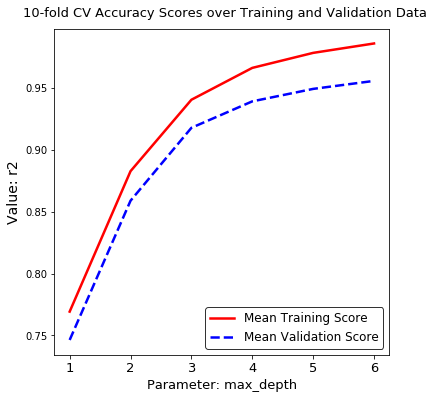

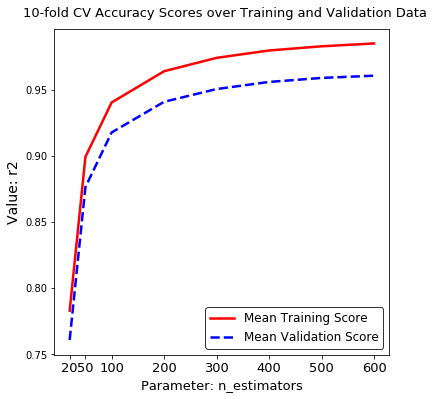

In [87]:
#Visualize results from dataframe
for i in range(0,len(param_grid_gbtree)):
    parameter_name = list(param_grid_gbtree[i])[0]
    gridsearch_scoreplot_nocombination(df_gbrt_res,'r2',parameter_name)

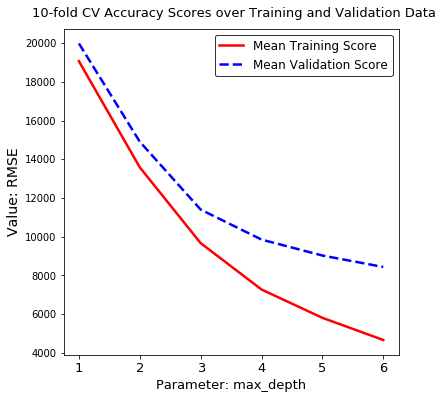

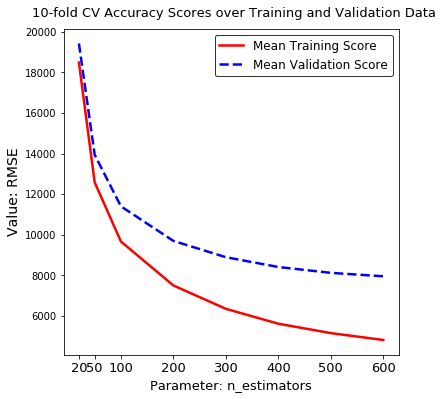

In [88]:
for i in range(0,len(param_grid_gbtree)):
    parameter_name = list(param_grid_gbtree[i])[0]
    gridsearch_scoreplot_nocombination(df_gbrt_res,'RMSE',parameter_name)

- Parameter: max_depth --> 4 is the sweet spot.
- Parameter: n_estimators --> 100 is the sweet spot.

__Fine Tuning Random Forest.__

In [90]:
rfr = RandomForestRegressor(random_state=42,n_jobs=-1,n_estimators=100)

param_grid_rf = [{'max_features':[0.1,0.2,0.3,0.4,0.5,0.6]},
                 {'max_depth':[2,3,4,5,6]},
                 {'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6]}]

grid_search_rf = GridSearchCV(rfr,param_grid_rf,cv=kfold,scoring=score_metric,refit='r2',return_train_score=True)
grid_search_rf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}, {'max_depth': [2, 3, 4, 5, 6]}, {'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}],
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['r2', 'neg_mean_squared_error'], verbose=0)

In [91]:
#View Results for Random Forest Regressor
df_rf_res = pd.DataFrame(grid_search_rf.cv_results_)

df_rf_res['mean_train_RMSE'] = np.sqrt(-df_rf_res.loc[:,'mean_train_neg_mean_squared_error'])
df_rf_res['mean_test_RMSE'] = np.sqrt(-df_rf_res.loc[:,'mean_test_neg_mean_squared_error'])
 
#view results.
df_rf_res.loc[:,(['param_max_features',
                  'param_max_depth',
                  'param_min_samples_split',
                  'mean_train_r2',
                  'mean_test_r2',
                  'mean_train_RMSE',
                  'mean_test_RMSE'])]

,param_max_features,param_max_depth,param_min_samples_split,mean_train_r2,mean_test_r2,mean_train_RMSE,mean_test_RMSE
0,0.1,NaN,NaN,0.990058,0.934359,3958.539368,10458.591830
1,0.2,NaN,NaN,0.992471,0.951016,3444.525790,9009.224522
2,0.3,NaN,NaN,0.993114,0.954470,3293.741489,8657.353666
3,0.4,NaN,NaN,0.993087,0.953315,3300.526099,8735.602450
4,0.5,NaN,NaN,0.993153,0.953092,3284.632408,8750.514132
5,0.6,NaN,NaN,0.993114,0.953870,3294.001247,8666.814952
6,NaN,2,NaN,0.589793,0.568773,25417.132474,26066.681362
7,NaN,3,NaN,0.677387,0.652755,22539.717234,23349.300460
8,NaN,4,NaN,0.753491,0.724120,19702.671723,20797.568480
9,NaN,5,NaN,0.818060,0.790012,16926.574989,18132.364516


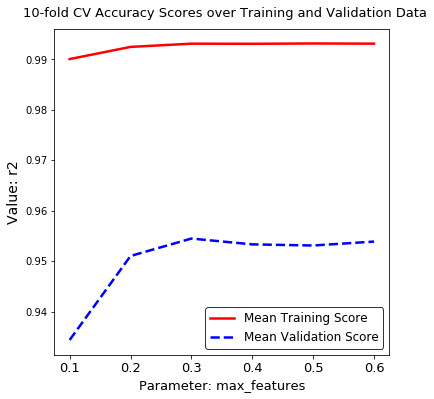

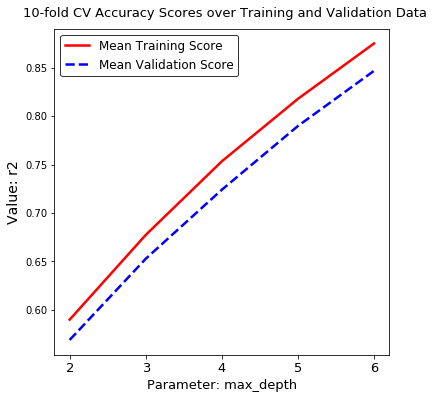

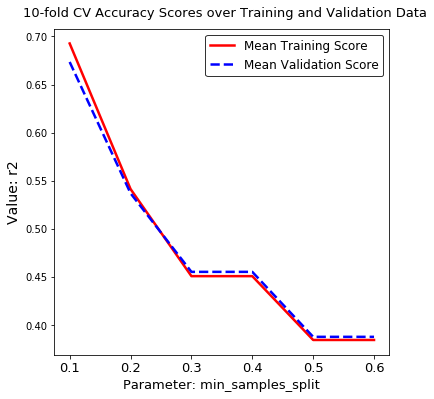

In [92]:
for i in range(0,len(param_grid_rf)):
    parameter_name = list(param_grid_rf[i])[0]
    gridsearch_scoreplot_nocombination(df_rf_res,'r2',parameter_name)

 - Parameter: min_samples_split did not improve the model. I decided to leave it untouched.
 - Parameter: max_depth kept increasing. With the values I selected I was underfitting. I decided it to leave it untouched.
 - Parameter: max_features I saw it increase and plateau. This indicates a sweet spot exists and I'll iterate further.
 - Paramter: n_estimators is next

In [95]:
rfr_v2 = RandomForestRegressor(random_state=42,n_jobs=-1)

param_grid_rf_v2 = [{'max_features':[0.2,0.25,0.3],'n_estimators':[20,50,100,200,300,400,500,600]}]

grid_search_rf_v2 = GridSearchCV(rfr_v2,param_grid_rf_v2,cv=kfold,scoring=score_metric,refit='r2',return_train_score=True)
grid_search_rf_v2.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_features': [0.2, 0.25, 0.3], 'n_estimators': [20, 50, 100, 200, 300, 400, 500, 600]}],
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['r2', 'neg_mean_squared_error'], verbose=0)

In [106]:
#View Results for Random Forest Regressor
df_rf_res_v2 = pd.DataFrame(grid_search_rf_v2.cv_results_)

df_rf_res_v2['mean_train_RMSE'] = np.sqrt(-df_rf_res_v2.loc[:,'mean_train_neg_mean_squared_error'])
df_rf_res_v2['mean_test_RMSE'] = np.sqrt(-df_rf_res_v2.loc[:,'mean_test_neg_mean_squared_error'])
 
#view results.
df_rf_res_v2.loc[:,(['param_max_features',
                     'param_n_estimators',
                     'mean_train_r2',
                     'mean_test_r2',
                     'mean_train_RMSE',
                     'mean_test_RMSE'])]

,param_max_features,param_n_estimators,mean_train_r2,mean_test_r2,mean_train_RMSE,mean_test_RMSE
0,0.2,20,0.990632,0.947459,3841.981801,9340.404686
1,0.2,50,0.992355,0.949541,3470.960744,9137.239878
2,0.2,100,0.992471,0.951016,3444.525790,9009.224522
3,0.2,200,0.992872,0.950659,3351.451432,9047.650281
4,0.2,300,0.992857,0.950503,3355.262059,9064.461603
5,0.2,400,0.992870,0.950628,3352.004234,9057.426368
6,0.2,500,0.992852,0.951038,3356.495057,9020.635279
7,0.2,600,0.992932,0.951108,3337.485422,9016.121983
8,0.25,20,0.990898,0.951703,3788.263216,8909.185580
9,0.25,50,0.992599,0.952009,3415.280888,8875.436786


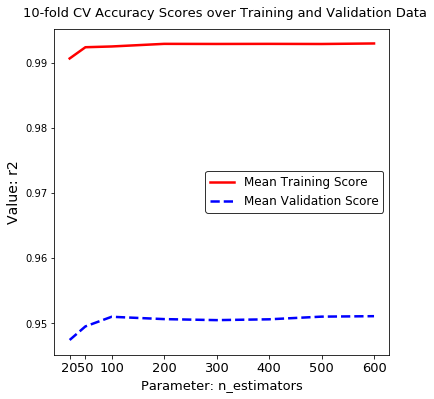

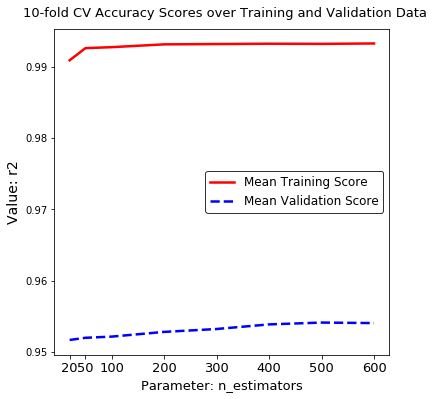

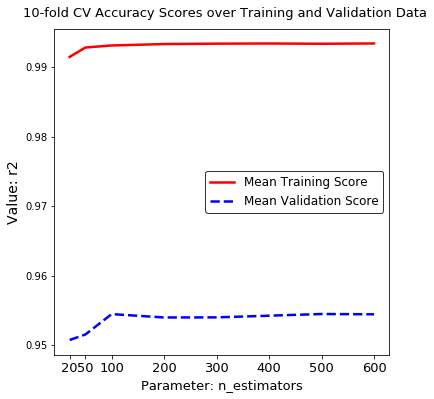

In [107]:
for max_feature in df_rf_res_v2.loc[:,'param_max_features'].unique():
    
    #Create Boolean Mask
    b_max_feature = df_rf_res_v2.loc[:,'param_max_features'] == max_feature
    
    gridsearch_scoreplot_nocombination(df_rf_res_v2.loc[b_max_feature,:],'r2','n_estimators')
    

### Test tuned parameter against the test set.

__Train against the test set. Gradient Boosted Tree Regressor.__

In [111]:
gbrt_final = GradientBoostingRegressor(n_estimators=100,max_depth=4,random_state=42)

gbrt_final.fit(X_test,y_test)
final_predictions_gbrt = gbrt_final.predict(X_test)

from sklearn.metrics import mean_squared_error

#Calculate RMSE
final_mse_gbrt = mean_squared_error(y_test,final_predictions_gbrt)
final_rmse_gbrt = np.sqrt(final_mse_gbrt)

final_score_gbrt = gbrt_final.score(X_test,y_test)

print('Test score: {:.2f}'.format(final_score_gbrt))
print('Test RMSE score: {:.2f}'.format(final_rmse_gbrt))

Test score: 0.97
Test RMSE score: 6862.53


In [108]:
rfr_final = RandomForestRegressor(n_estimators=100,max_features=0.3,random_state=42,n_jobs=-1)

rfr_final.fit(X_test,y_test)
final_predictions_rfr = rfr_final.predict(X_test)

from sklearn.metrics import mean_squared_error

#Calculate RMSE
final_mse_rfr = mean_squared_error(y_test,final_predictions_rfr)
final_rmse_rfr = np.sqrt(final_mse_rfr)

#Calculate r2 Score
final_score_rfr = rfr_final.score(X_test,y_test)

print('Test score: {:.2f}'.format(final_score_rfr))
print('Test RMSE score: {:.2f}'.format(final_rmse_rfr))

Test score: 0.98
Test RMSE score: 5963.81


_The models generalized well with the test set. Both achieved scores > 97% and the errors are managable._